# House Prices: Advanced Regression Techniques

<blockquote>Predict sales prices and practice feature engineering, RFs, and gradient boosting</blockquote>

Competirion [homepage](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)

In [181]:
import math
import pandas as pd
import numpy as np
import os

# Do not use normal form (scietific notation) when printing numbers, exponents can make it harder to compare values
pd.set_option('float_format', '{:f}'.format)

import matplotlib.pyplot as plt
import seaborn as sns
#%pylab inline
# pylab.rcParams['figure.figsize'] = (15, 6)

import sklearn
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import Imputer, StandardScaler

In [116]:
'numpy: {}, pandas: {}, sklearn: {}'.format(np.__version__, pd.__version__, sklearn.__version__)

'numpy: 1.14.5, pandas: 0.23.3, sklearn: 0.19.1'

#### To do

* feature extraction
* Lasso model
* Ridge model
* Decision tree regressor
* Bagging
* Random Forest
* Boosting

## Import

In [117]:
competition_name = "house-prices-advanced-regression-techniques"
data_path = "..\datasets\kaggle\house-prices"

In [118]:
def read_data(filename):
    return pd.read_csv(os.path.join(data_path, filename), index_col="Id")

In [119]:
train_data = read_data("train.csv")
test_data = read_data("test.csv")

In [120]:
X_train = train_data.drop(["SalePrice"], axis=1)
y_train = train_data["SalePrice"].copy()
X_test = test_data.copy()

## Explore

In [74]:
pd.set_option('display.max_columns', X_train.shape[1])

In [75]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.000000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.000000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.000000,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.000000,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.000000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [76]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 79 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [77]:
X_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [78]:
X_train.describe(include=['O'])

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1452,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,4,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,864,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000243BBC84DD8>,
      dtype=object)

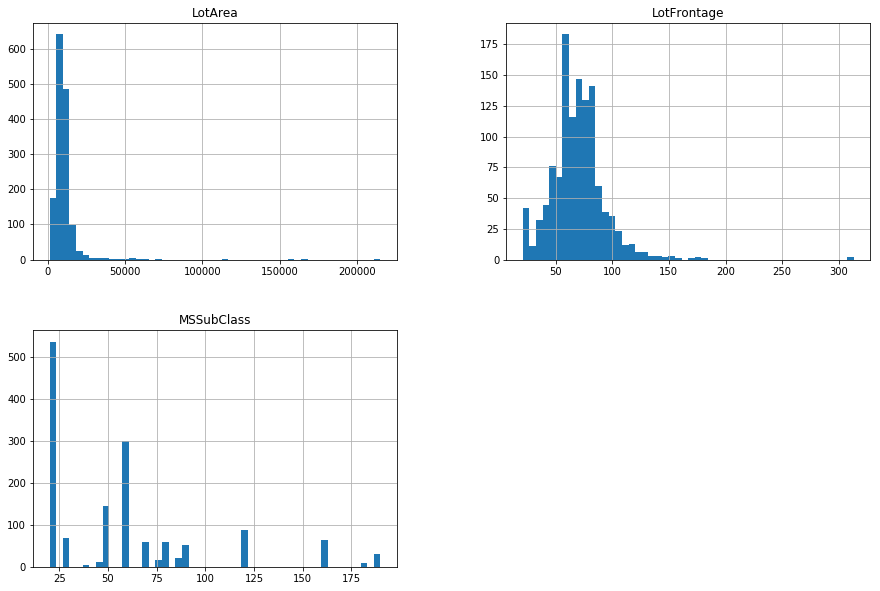

In [227]:
X_train[["LotArea", "MSSubClass", "LotFrontage"]].hist(bins=50, figsize=(15,10))

Look for correlations with the target value

In [80]:
corr_matrix = train_data.corr()

In [81]:
corr_matrix["SalePrice"].sort_values(ascending=False)[1:]

OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [82]:
pd.reset_option('display.max_columns')

In [83]:
X_train.shape

(1460, 79)

## Transform

 - numeric, insert mean
 - object, insert frequent
 - object, one hot encode
 - normalise

In [121]:
class ImputerTransformer(BaseEstimator, TransformerMixin):
    """Transformer that imputes missing values"""    
    
    def __init__(self, strategy="mean"):
        self.strategy=strategy
    def fit(self, X, y=None):
        self.imputer = Imputer(strategy=self.strategy).fit(X)
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return pd.DataFrame(self.imputer.transform(X), index=X.index, columns=X.columns)

In [122]:
class FillNaMostCommonTransformer(BaseEstimator, TransformerMixin):
    """Transformer that fills na with most common value
    
    If all values in a column are na column will be filled with the fallback value
    """    
    
    def __init__(self, fallback="EMPTY"):
        self.fallback=fallback
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.apply(lambda x: x.fillna(self.__getMostCommonValue(x)))
    def __getMostCommonValue(self, s):
        return s.value_counts().index[0] if s.any() else self.fallback

In [123]:
class SelectColumnsTransformer(BaseEstimator, TransformerMixin):
    """Transformer that selects a set of columns"""
    
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X[self.columns]

In [124]:
class GetDummiesTransformer(BaseEstimator, TransformerMixin):
    """Transformer that one-hot encodes the given columns"""
    
    def __init__(self, columns=None, drop_first=False):
        self.columns = columns
        self.drop_first=drop_first
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return pd.get_dummies(X, columns=self.columns, drop_first=self.drop_first)

The object columns in the test and train sets contain different categories, so if we get dummies for the two datasets we'll end up with transformed datasets that contain different numbers of columns, prediction on the test set will then fail. As a workaround we'll combine the test and train sets and get ddummies for the combined data, then split apart into train and test data again. That said, it does have the advantage of converting all data to numeric, removing the need for separate object and numberic pipelines.
This is not ideal as training involves knowledge of the training data, but it'll do for a Kaggle competition. 

In [125]:
from pandas.api.types import CategoricalDtype

all_data = pd.concat((X_train, X_test))

for column in all_data.select_dtypes(include=[np.object]).columns:
    unique_values = all_data[column].dropna().unique()
    
    X_train[column] = X_train[column].astype(CategoricalDtype(categories=unique_values))
    X_test[column] = X_test[column].astype(CategoricalDtype(categories=unique_values))

Build a transformation pipeline

In [126]:
transformation_pipeline = Pipeline([
    ("get_dummies", GetDummiesTransformer()),
    ("impute_values", ImputerTransformer()),
    ("std_scaler", StandardScaler())
])

Verify the transformer

In [127]:
X_train_transformed=transformation_pipeline.fit_transform(X_train)

In [128]:
X_train_transformed[:5]

array([[ 0.07337496, -0.22937175, -0.20714171, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [-0.87256276,  0.4519361 , -0.09188637, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [ 0.07337496, -0.09311018,  0.07347998, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [ 0.30985939, -0.45647437, -0.09689747, ..., -0.05241424,
        -0.09103457, -0.11785113],
       [ 0.07337496,  0.63361819,  0.37514829, ..., -0.05241424,
        -0.09103457, -0.11785113]])

## Train

### Baseline

In [129]:
from sklearn.dummy import DummyRegressor

In [130]:
clf_dummy = DummyRegressor(strategy='median')

In [131]:
dummy_pipeline = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('dummy_clf', clf_dummy)
])

In [132]:
dummy_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('prepare_data', Pipeline(memory=None,
     steps=[('get_dummies', GetDummiesTransformer(columns=None, drop_first=False)), ('impute_values', ImputerTransformer(strategy='mean')), ('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('dummy_clf', DummyRegressor(constant=None, quantile=None, strategy='median'))])

In [133]:
y_hat_dummy = dummy_pipeline.predict(X_test)

### LinearRegression

In [217]:
from sklearn.linear_model import LinearRegression

In [218]:
clf_lnr = LinearRegression()

In [219]:
pipeline_lnr = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('dummy_clf', clf_lnr)
])

In [220]:
pipeline_lnr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('prepare_data', Pipeline(memory=None,
     steps=[('get_dummies', GetDummiesTransformer(columns=None, drop_first=False)), ('impute_values', ImputerTransformer(strategy='mean')), ('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('dummy_clf', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False))])

In [221]:
y_hat_lnr = pipeline_lnr.predict(X_test)

In [234]:
from sklearn.utils import check_consistent_length

check_consistent_length(y_train, y_hat_lnr)

ValueError: Found input variables with inconsistent numbers of samples: [1460, 1459]

Get the model's RMSE

In [229]:
lin_mse = mean_squared_error(y_train, y_hat_lnr)
lin_rmse = np.sqrt(lin_mse)

ValueError: Found input variables with inconsistent numbers of samples: [1460, 1459]

In [230]:
scores_lnr = cross_val_score(pipeline_lnr, X_train, y_train, cv=5)

In [231]:
"Accuracy: {0:.2f} (+/- {0:.2f}".format(scores_lnr.mean(), scores_lnr.std() * 2)

'Accuracy: -1587784707559637253095424.00 (+/- -1587784707559637253095424.00'

### LinearSVC

Run a pipeline consisting of a transformation and a classifier, with no hyperparameter searching.

In [110]:
from sklearn.svm import LinearSVC

In [111]:
clf_svc = LinearSVC(penalty="l2", dual=False, tol=1e-4)

In [112]:
svc_pipeline = Pipeline([
    ('prepare_data', transformation_pipeline),
    ('svc_clf', clf_svc)
])

In [113]:
svc_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('prepare_data', Pipeline(memory=None,
     steps=[('get_dummies', GetDummiesTransformer(columns=None, drop_first=False)), ('impute_values', ImputerTransformer(strategy='mean')), ('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('svc_clf', LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))])

In [114]:
y_hat_svc = svc_pipeline.predict(X_test)

## Evaluate

## Submit

In [107]:
submission = pd.DataFrame({
  "Id": X_test.index,
  "SalePrice": y_hat_svc
})

In [108]:
submission.to_csv(data_path + "/submission.csv", index=False)

In [109]:
!kaggle competitions submit -c $competition_name -f $data_path/submission.csv -m "linearregression scaled data"

Successfully submitted to House Prices: Advanced Regression Techniques


Jump to the [leaderboard](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard) to see the score and ranking

## Summary

| Model              | Notes                            | Kaggle score  |    Leaderboard |
| ------------------ | -------------------------------- | ------------- | -------------- |
| `DummyRegressor`   | Baseline                         |       0.41889 |  4,457 / 4,622 |
| `LinearSVC`        | No parameter searching           |       0.29999 |  4,309 / 4,622 |
| `LinearRegression` | No searching                     |       0.20012 |  3,886 / 4,579 |
|                    |                                  |               |                |
|                    |                                  |               |                |
|                    |                                  |               |                |
